# Predicting Heart Disease
The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, we will use the Kaggle dataset and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

In [156]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [157]:
df = pd.read_csv('datasets/heart.csv')
df.shape

(918, 12)

In [158]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### EDA: Descriptive Statistics

In [159]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [160]:
df.dtypes.value_counts()

int64      6
object     5
float64    1
Name: count, dtype: int64

7 features in total are numerical while 5 are categorical. However, two of the numerical features, FastingBS and HeartDisease are categorical as well.

We will focus on the numerical variables first.

In [161]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the table above, we can observe that:

- The average age of patients is ~53 years.
- The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- RestingBP and Cholesterol have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

RestingBP can't be 0. And, as per the American Heart Association, serum cholesterol is a composite of different measurements. So, it is unlikely that Cholesterol would be 0 as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, HeartDisease, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [162]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in this dataset!

In [163]:
df.describe(include='object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


We can confirm that those columns are indeed categorical given the number of unique values in each of them. But, we can't gather much else. Also, FastingBS and HeartDisease are categorical as well since they only contain binary values. We can confirm that quickly as well.

In [164]:
df["HeartDisease"].unique(), df["FastingBS"].unique()

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

### EDA: Visualizations

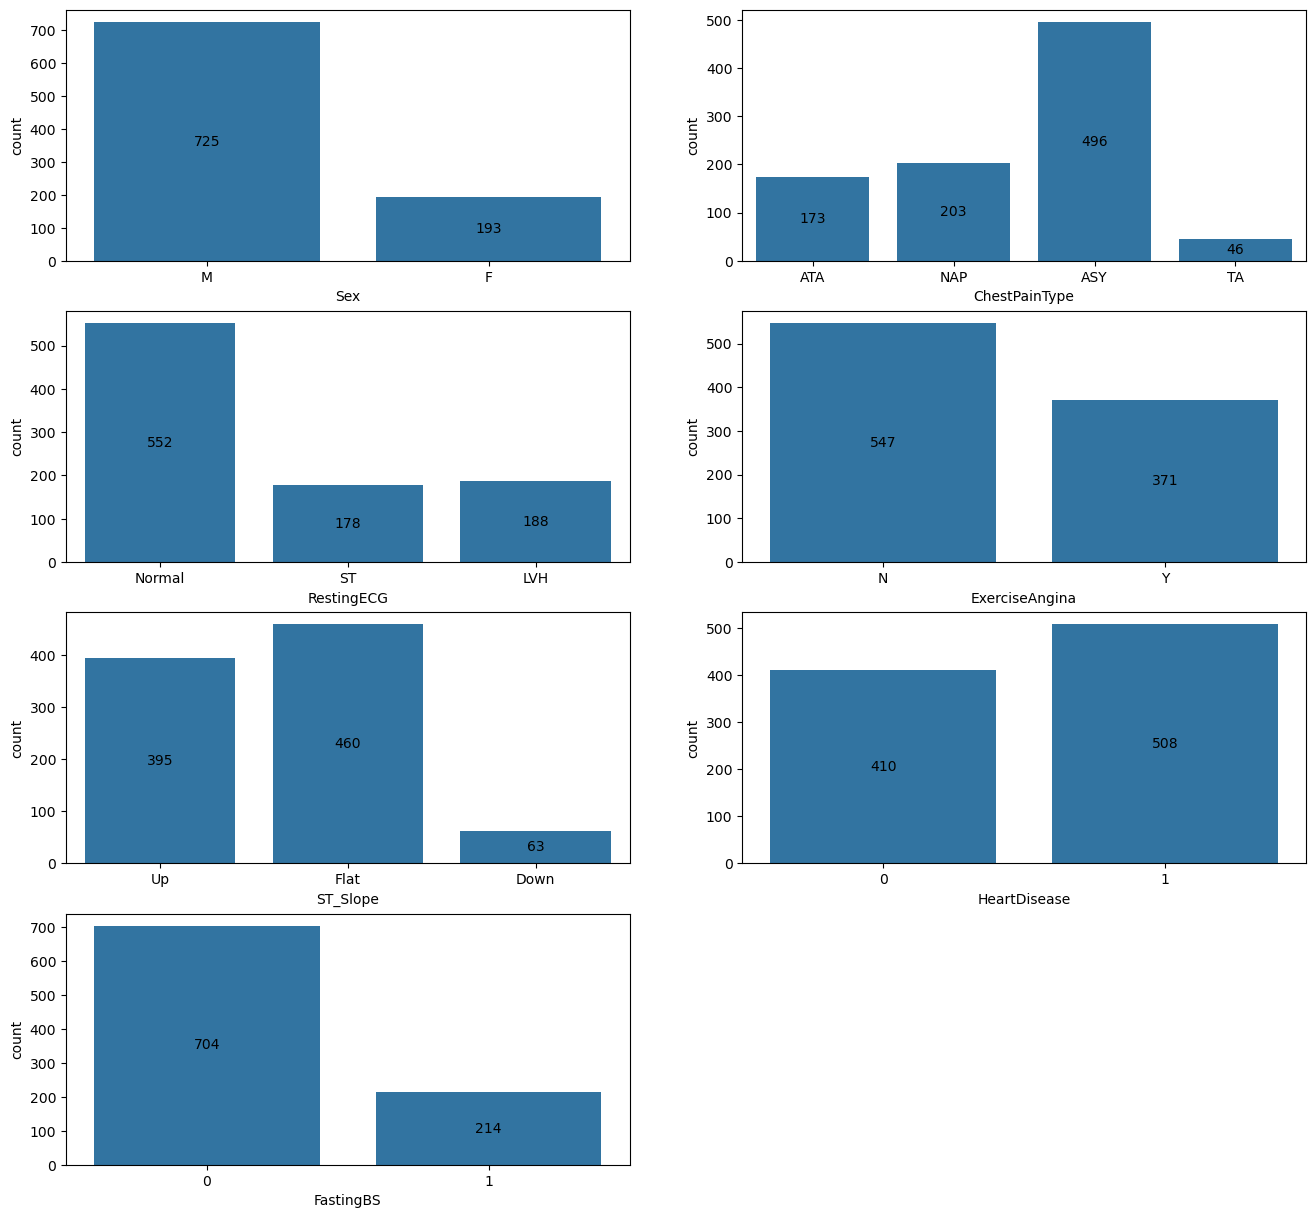

In [165]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- The dataset is highly skewed towards male patients. There are 725 male patients and 193 female patients. This could potentially induce a bias in our model.
- 496 patients had ASY (asymptotic) chest pain type.
- 552 patients had a normal restin ECG.
- 704 patients had blood sugar lower than 120 mg/dl

Grouping these by HeartDisease will give us a better idea about the data distribution.

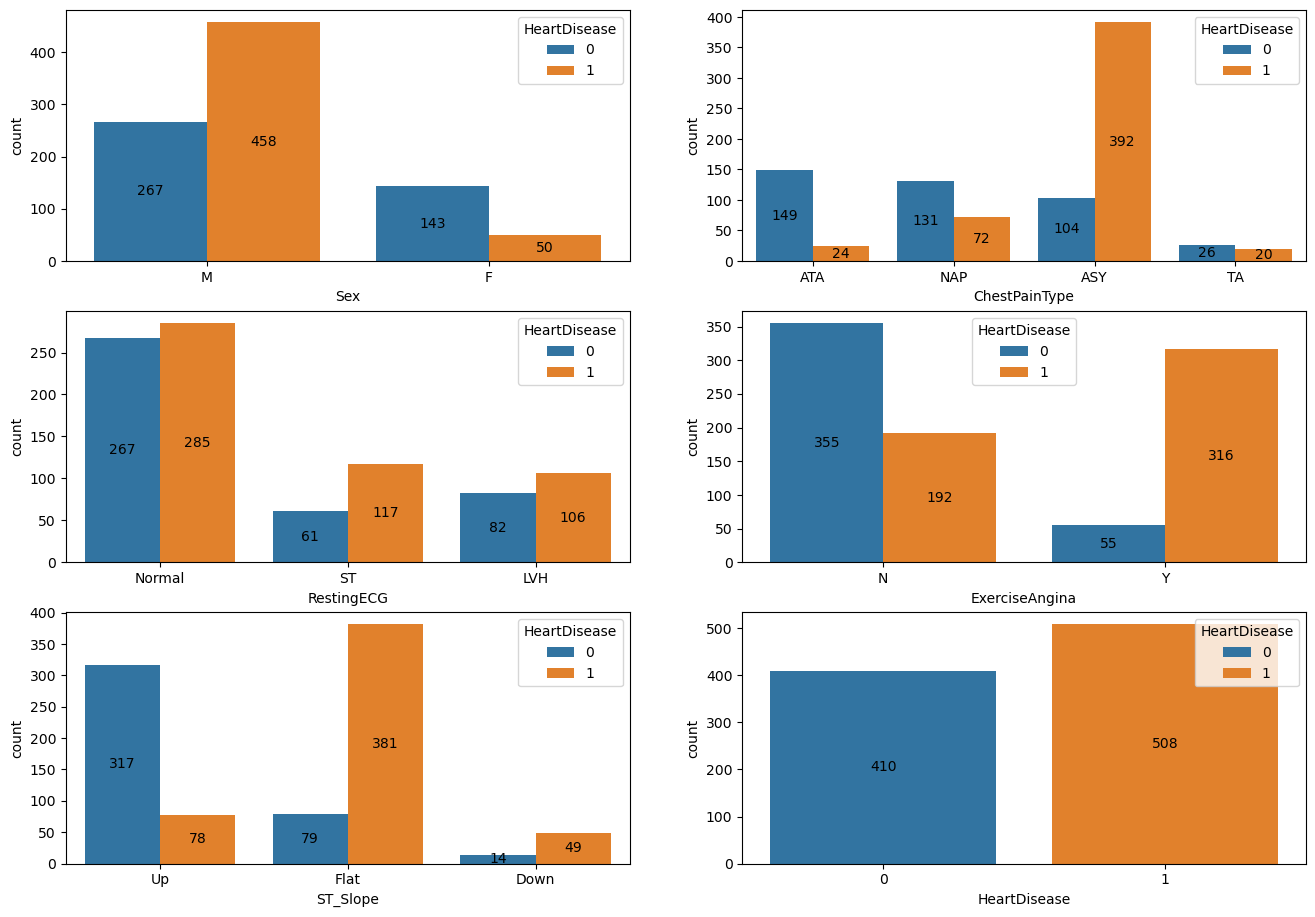

In [166]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
- A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

In [167]:
median_age = df[df['HeartDisease']==1]['Age'].median()
median_age

57.0

We can notice that median age of patients who were diagnosed with heart disease is 57 years

### Data Cleaning

We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values RestingBP and Cholesterol contain and decide how to handle those.

In [168]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [169]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


RestingBP has only one zero value. We can remove that row from consideration. There are 172 zero values for Cholesterol. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in Cholesterol in relation to HeartDisease. So, the 0 values in Cholesterol for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [170]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

df_clean.loc[df["HeartDisease"] == 0, 'Cholesterol']=df_clean.loc[df["HeartDisease"] == 0, 'Cholesterol'].replace(to_replace=0, value=df_clean.loc[df["HeartDisease"] == 0, 'Cholesterol'].median())
df_clean.loc[df["HeartDisease"] != 0, 'Cholesterol']=df_clean.loc[df["HeartDisease"] != 0, 'Cholesterol'].replace(to_replace=0, value=df_clean.loc[df["HeartDisease"] != 0, 'Cholesterol'].median())

In [171]:
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


### Feature Selection

In [172]:
df_clean=pd.get_dummies(data=df_clean, drop_first=True).astype(int)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,1,0,1,0,1,0,0,0,1


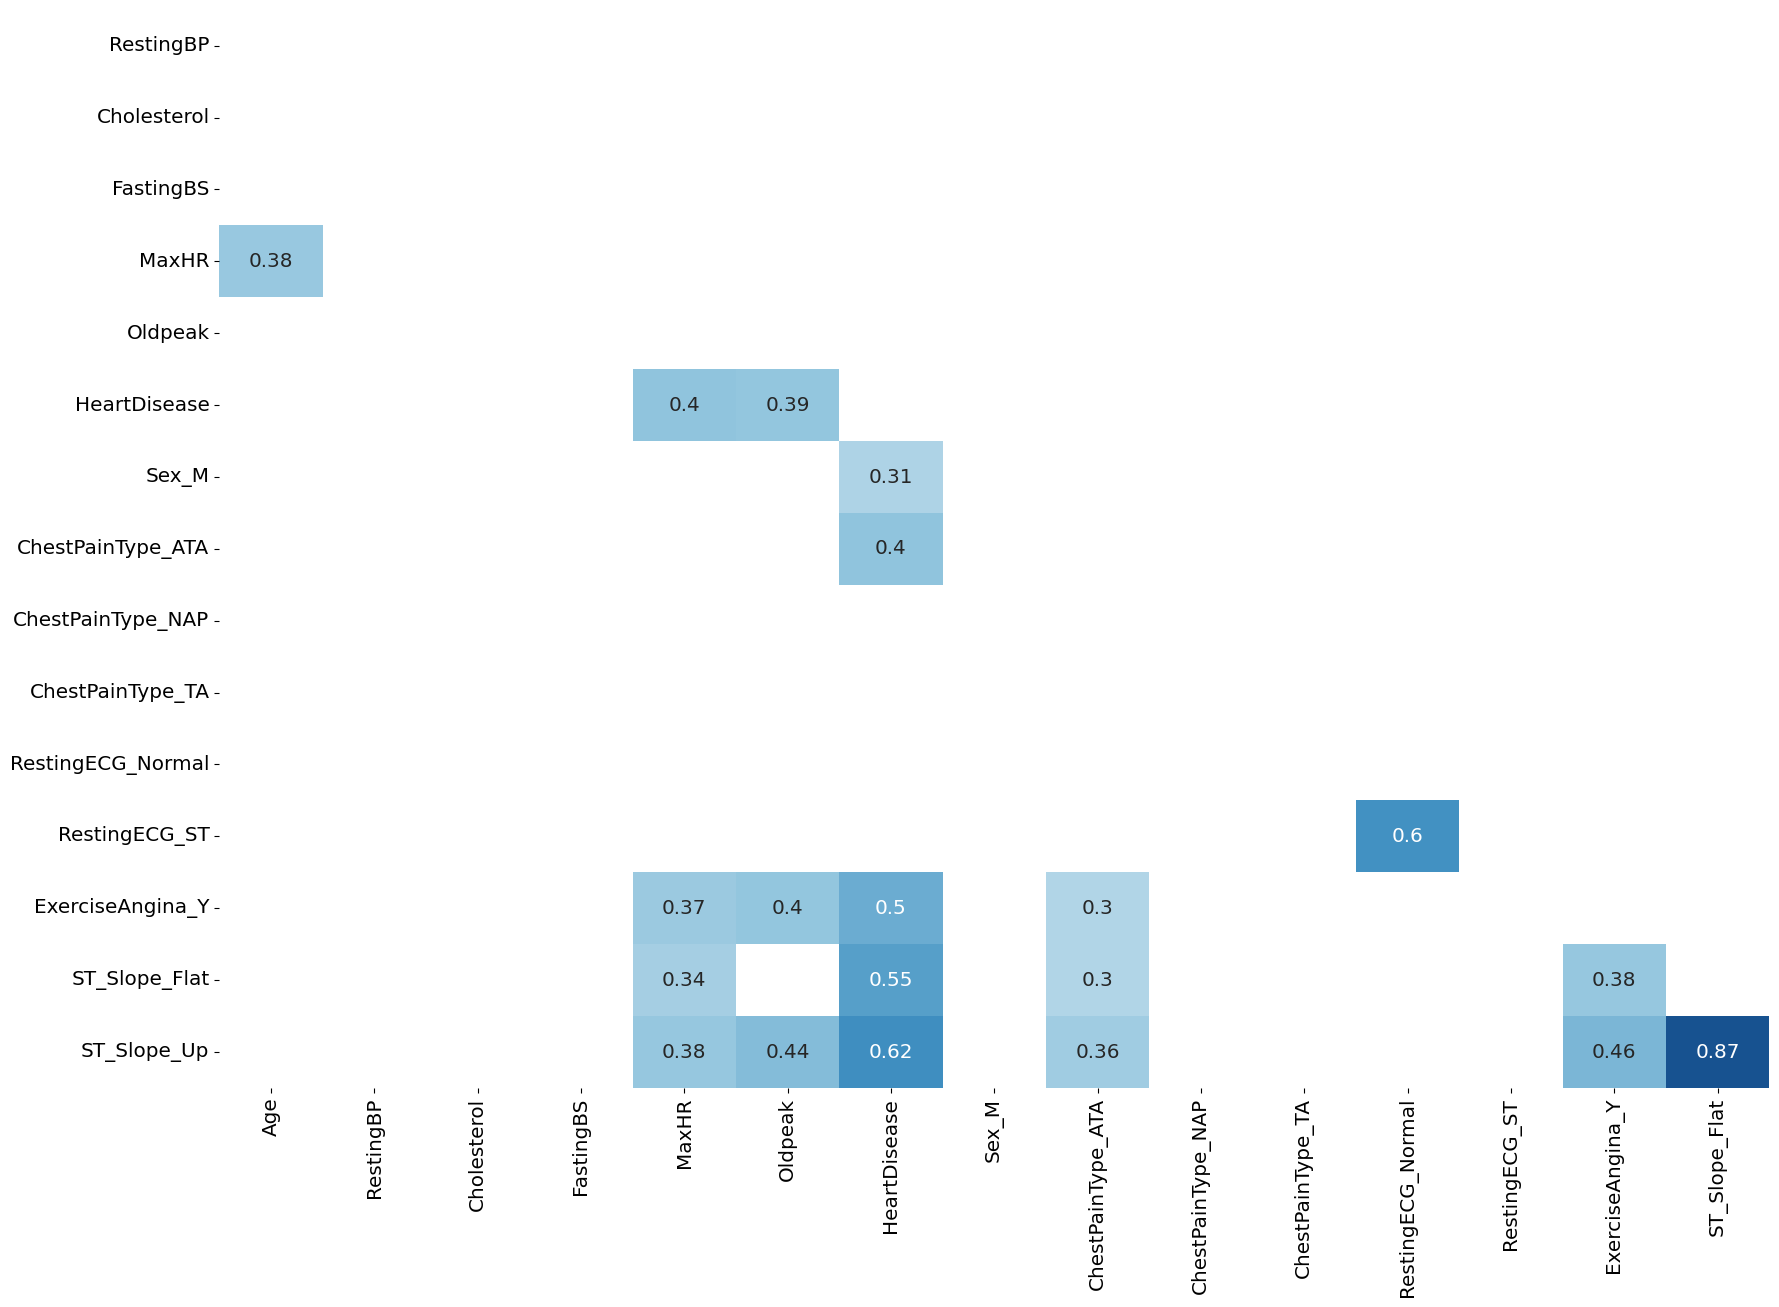

In [173]:
def plot_correlations(df):
    # create a correlation matrix
    corr = abs(df.corr())
    # create a mask to avoid repeated values and make
    # the plot easier to read
    corr = corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(corr[corr>0.3], vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

plot_correlations(df_clean)

Given everything we have attempted so far, we can narrow down our features which are highly correlated to the heart disease to the following:
- Sex_M
- ChestPainType_ATA
- ChestPainType_NAP
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_UP

### Building a Classifier with One Feature

In [174]:
X = df_clean.drop(['HeartDisease'], axis=1)
y=df_clean['HeartDisease']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=417)

In [175]:
features = ['Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

for feature in features:
    knn=KNeighborsClassifier(n_neighbors=6)
    knn.fit(X_train[[feature]], y_train)
    accuracy=knn.score(X_val[[feature]], y_val)
    print(f'Feature: {feature}, Accuracy: {accuracy}')

Feature: Sex_M, Accuracy: 0.44021739130434784
Feature: ChestPainType_ATA, Accuracy: 0.44021739130434784
Feature: ChestPainType_NAP, Accuracy: 0.44021739130434784
Feature: ExerciseAngina_Y, Accuracy: 0.7119565217391305
Feature: ST_Slope_Flat, Accuracy: 0.782608695652174
Feature: ST_Slope_Up, Accuracy: 0.8097826086956522


Our best forming model, with an accuracy of 80%, was trained on the ST_Slope_Up feature with ST_Slope_Flat being a close second. These make sense given the data distributions we saw previously.

We will train a model using all of these features next.

### Building a Classifier with Multiple Features

In [176]:
scaler = MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train[features])
X_val_scaled=scaler.fit_transform(X_val[features])

In [177]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_scaled, y_train)
accuracy=knn.score(X_val_scaled,y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 85.87


The model's accuracy jumped to about 86%! That's not a significant improvement, but still a good start. Using all these features results in an improved model, but, let's see what parameters/hyperparameters might be optimal.

### Hyperparameter Optimization

In [178]:
X_train, X_test, y_train, y_test=train_test_split(X[features], y, test_size=0.2, random_state=417)
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [179]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }
knn=KNeighborsClassifier()
knn_grid=GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)
best_model=knn_grid.best_estimator_
best_parameters=knn_grid.best_params_
best_accuracy=knn_grid.best_score_
print(f'Best params are: {best_parameters}')
print(f'Best accuracy is: {best_accuracy*100:.2f} %')

Best params are: {'metric': 'minkowski', 'n_neighbors': 17}
Best accuracy is: 84.58 %


Our best model had an accuracy of 85% with 17 n_neighbors and minkowski as the distance metric.

The accuracy of this model is slightly worse. Since GridSearchCV employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

### Model Evaluation on Test Set

In [181]:
accuracy=best_model.score(X_test_scaled, y_test)
print(f" Model Accuracy on test set: {accuracy*100:.2f} %")

 Model Accuracy on test set: 85.87 %


Our model got an accuracy of ~86%. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~86% of the time.

However, the accuracy being higher than the one before raises some flags.

One explanation that could explain is to look at how the data is distributed.

In [182]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
1    724
0    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
1    580
0    153
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
1    144
0     40
Name: count, dtype: int64


We can see that the above datasets have a significantly higher number of male patients than female ones. This could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.